# Sindy
System identification refers to the process of leveraging measurement data to infer governing equations, in the form of dynamical systems, describing the data. Once discovered, these equations can make predictions about future states, can inform control inputs, or can enable the theoretical study using analytical techniques. Dynamical systems are a flexible, well-studied class of mathematical objects for modeling systems evolving in time. SINDy is a model discovery method which uses sparse regression to infer nonlinear dynamical systems from measurement data. The resulting models are inherently interpretable and generalizable.

#### >>>> Useful articles and material here <<<<
- [PySINDy:  A Python package for the SparseIdentification of Nonlinear Dynamics from Data](https://arxiv.org/pdf/2004.08424.pdf)
- [PySINDy DOCS](https://pysindy.readthedocs.io/en/latest/examples/index.html)
- [PySINDy git](https://github.com/dynamicslab/pysindy)

### How it works
Suppose, for some physical system of interest, we have measurements of state variables $x(t)$ (a vector of length n) at different points in time. Examples of state variables include the position, velocity, or acceleration of objects; lift, drag, or angle of attack of aerodynamic objects; and concentrations of different chemical species. If we suspect that the system could be well-modeled by a dynamical system of the form:

$$x'(t)= f(x(t))$$

then we can use SINDy to learn $f(x)$ from the data ($x'(t)$ denotes the time derivative of $x(t)$). Note that both $f(x)$ and $x(t)$ are typically vectors. The fundamental assumption SINDy employs is that each component of $f(x)$, $f_i(x)$ can be represented as a sparse linear combination of basis functions $\theta_j(x)$ 

```f_i(x) = theta_1(x) * xi_{1,i} + theta_2(x) * xi_{2,i} + ... + theta_k * xi{k,i}```


Concatenating all the objects into matrices (denoted with capitalized names) helps to simplify things. To this end we place all measurements of the state variables into a data matrix $X$ (with a row per time measurement and a column per variable), the derivatives of the state variables into a matrix ```X'```, all basis functions evaluated at all points in time into a matrix ```Theta(X)``` (each basis function gets a column), and all coefficients into a third matrix ```Xi``` (one column per state variable). The approximation problem to be solved can then be compactly written as:

```X' = Theta(X)*Xi```

## Main ideas
Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$ 
	\frac{dx(t)}{dt} = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## Approximation problem
To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). If we have only one variable, we are left with a single column vector. These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

If one does not have the time derivative, we can use the already implemented package for numerical differentiation. 

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then 

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

### View of SINDy for Lorenz Equations

![View of SINDy for Lorenz Equations](Schematic-of-the-SINDy-algorithm-demonstrated-on-the-Lorenz-equations-Data-are.png)

We measure the state for a Lorenz system $[x(t), y(t), z(t), \dot{x(t)}, \dot{y(t)}, \dot{z(t)}]$. We obtain the matrix $\dot{X}$. 
Then, if we choose a library matrix consisting of polynomials to degree up to five, we build the matrix $\Theta(X)$. Then we try sparse linear combination that recreates the dynamic. The sparse matrix identifies the active terms from the library. Hopefully, we get some model that can recreates the system.


In [143]:
import numpy as np
import pysindy as ps
import pandas as pd

Suppose we have measurements of the position of a particle obeying the following dynamical system at different points in time:
$$\frac{d}{dt} \begin{bmatrix}
x\\
y\\
\end{bmatrix}=
\begin{bmatrix}
-2x\\
y\\
\end{bmatrix}=
\begin{bmatrix}
-2 & 0 \\
0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
x\\
y\\
\end{bmatrix}
$$
Easily, we can decouples into:
$$
x' = -2x \rightarrow x(t)=x_0e^{-2t} \\
y' = y \rightarrow y(t)=y_0e^t
$$

Choosing now $x_0 = 3$ and $y_0 = 1/2$, we construct the matrix $X$

In [144]:
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)

In [145]:
X = np.stack((x, y), axis=-1) 

We want to compute the derivatives now: while we could use this method to compute $\dot X$ "by hand," it is often more convenient to pass it into the `SINDy` object and let the computation of $\dot X$ be handled automatically.



In [146]:
differentiation_method = ps.SmoothedFiniteDifference(order=2)

The candidate library can be specified with an object from the `feature_library` submodule, which will also be passed into the `SINDy` object.

In [193]:
feature_library = ps.PolynomialLibrary(degree=3)
feature_library.

PolynomialLibrary(degree=3)

Next we select which optimizer should be used.

In [148]:
optimizer = ps.STLSQ(threshold=0.2)

In [149]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

In [150]:
model.fit(X, t=t)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=PolynomialLibrary(degree=3), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [151]:
model.print()

x' = -2.000 x
y' = 1.000 y


Let's see now, if we can handle new initial conditions.

In [152]:
x0 = 6
y0 = -0.1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model.simulate([x0, y0], t=t_test)

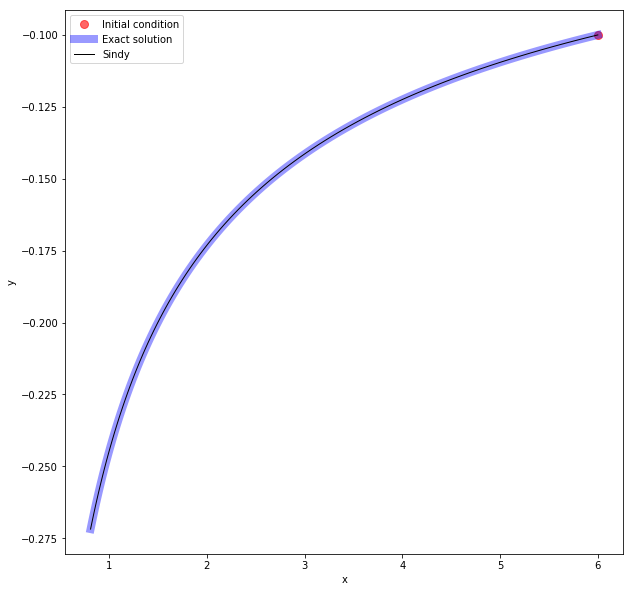

In [153]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
ax.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=8)
ax.plot(sim[:,0], sim[:,1],'k', label="Sindy", linewidth=1)
ax.set(xlabel="x", ylabel="y")
ax.legend()

Note that if the library we had chosen had been inappropriate for the problem at hand (i.e. if the dynamics could not be well-approximated as a sparse linear combination of library functions), then SINDy would have failed to produce a reasonable model. For example, if we solve the same problem, but using sines and cosines as our basis functions, SINDy is unable to find a sparse model for the dynamics:


In [154]:
# Populate the library with trigonometric functions
feature_library = ps.FourierLibrary()

model_sc = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
model_sc.fit(X, t=t)
model_sc.print()

x' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
y' = 1.362 sin(1 y) + -0.222 cos(1 y)


In [155]:
sim_sc = model_sc.simulate([x0, y0], t=t_test)

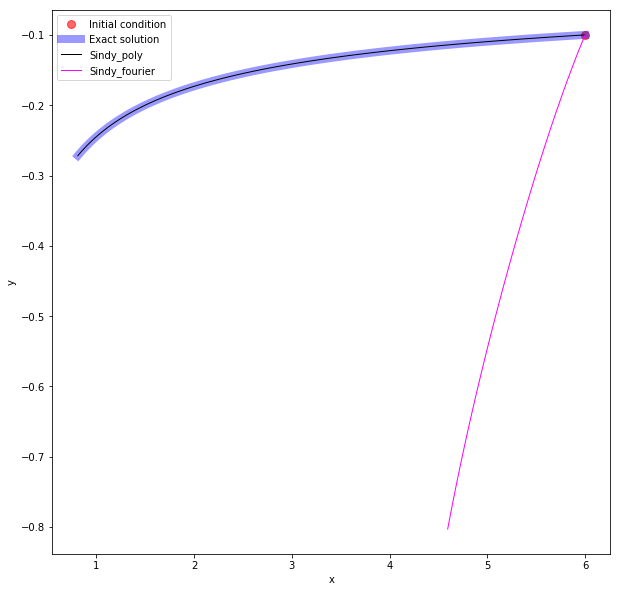

In [156]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
ax.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=8)
ax.plot(sim[:,0], sim[:,1],'k', label="Sindy_poly", linewidth=1)
ax.plot(sim_sc[:,0], sim_sc[:,1],'magenta', label="Sindy_fourier", linewidth=1)
ax.set(xlabel="x", ylabel="y")
ax.legend()

Una merda

In [157]:
model = ps.SINDy(feature_names=["x", "y"])

In [158]:
model.fit(X,t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x', 'y'],
      optimizer=STLSQ())

In [159]:
model.print()

x' = -2.000 x
y' = 1.000 y


# The Different Band Experiment


In [259]:
df = pd.read_csv('allcvs.csv')

In [264]:
df = df[df.star=='V18']
df.dtypes

AP0_step     object
HJD         float64
errmag      float64
filter       object
mag         float64
phase       float64
star         object
subset       object
dtype: object

In [162]:
lcv0 = lcvs[lcvs['star']=='rrl_hires_asaslcvs/160342+0036.0_ap0_1.fas']
lcv0.columns

Index(['Unnamed: 0', 'HJD', 'phase', 'mag', 'errmag', 'AP0_step', 'star'], dtype='object')

In [163]:
X = lcv0[['phase', 'mag']]

In [164]:
t = X['phase']

In [165]:
model = ps.SINDy(feature_names=['mag'])

 DataFrame.sort_values(by, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)[source]

In [166]:
X = X.sort_values(by='phase')

In [167]:
t = X['phase']

<ErrorbarContainer object of 3 artists>

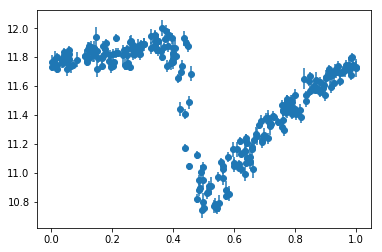

In [168]:
#plt.scatter(lcv0.phase, lcv0.mag)
plt.errorbar(lcv0.phase, lcv0.mag, yerr=lcv0.errmag, fmt='o')

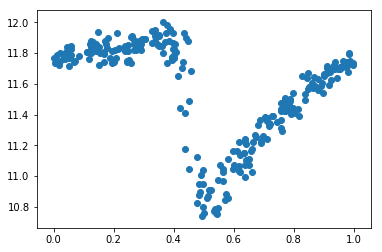

In [169]:
import matplotlib.pyplot as plt
plt.scatter(t, X.mag)

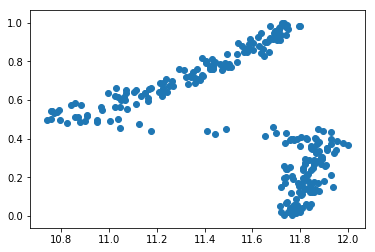

In [170]:
plt.scatter(X.mag, t)

In [171]:
X = pd.DataFrame.drop_duplicates(X, subset='phase')

In [172]:
lcv1 = lcvs[lcvs['star']=='rrl_hires_asaslcvs/203815-0253.5_ap0_1.fas']
X1 = lcv1[['phase', 'mag']]
X1 = X1.sort_values(by='phase')
X1 = pd.DataFrame.drop_duplicates(X1, subset='phase')
X1_rep = []
for i in range(2):
    X1_rep.append(X1)

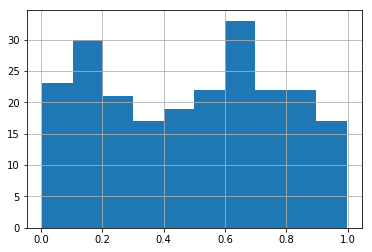

In [173]:
X1.phase.hist()

In [174]:
X1_fin = pd.concat(X1_rep)

In [175]:
def repeat_df(df, add_phase):
    df2 = pd.DataFrame.copy(df)
    df2['phase'] += add_phase
    return pd.concat([df, df2])

In [176]:
df_4 = repeat_df(repeat_df(X1,1),2)

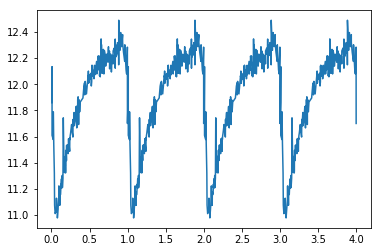

In [177]:
plt.plot(df_4.phase, df_4.mag)

## Repetition for all star


The light curve can be modeled like mag(t) = f(t)

In [49]:
spline_derivative = ps.SINDyDerivative(kind="spline", s=1e-2)

In [50]:
prova_der = Light_Curve('rrl_hires_asaslcvs/000248-2456.7_ap0_1.fas')

In [51]:
prova_der.sort_and_drop('phase')
#df = prova_der.find_df()
df = prova_der.df

In [178]:
from scipy import interpolate

def cheb_nodes(N):

    jj = 2.*np.arange(N) + 1

    x = np.cos(np.pi * jj / 2 / N)[::-1]

    return x


t = np.array(df.phase)
x = np.array(df.mag)



tck = interpolate.splrep(t, x, k=3, s=1)
t_test = np.linspace(0,1,1000)
x_test = interpolate.splev(t_test, tck, der=0)
x_dot_test = interpolate.splev(t_test, tck, der=1)

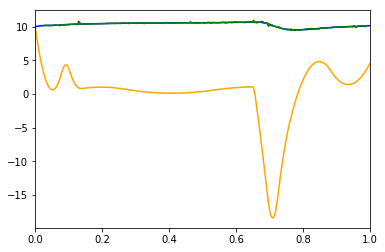

In [53]:
plt.xlim([0,1])
#plt.ylim([-100,12])
plt.plot(t_test, x_test, 'blue')
plt.plot(t_test, x_dot_test, 'orange')
plt.plot(t,x, 'green')
#pd.DataFrame({'t': t_test, 'x' : x_test, 'xdot': x_dot_test})

### Custom Class

In [179]:
from pysindy.optimizers import STLSQ
from pysindy.feature_library import PolynomialLibrary
from pysindy import FiniteDifference
import plotly.express as px
from sklearn.linear_model import Lasso

In [180]:
class Light_Curve:
    def __init__(self, name):
        self.name = name
        self.phase = []
        self.df = []
        
    def check_class(self):
        print('The name of the star is ' + self.name)
    
    def find_phase(self):
        with open(self.name) as f:
            self.first_line = f.readline()
            self.phase = float(self.first_line[18:-18])
            return self.phase
    
    def find_df(self):
        self.columns_name = ['HJD', 'phase', 'mag', 'errmag', 'AP0_step']
        self.df = pd.read_csv(self.name,index_col=False, header=0, names = ['HJD'], comment='#')
        self.df = pd.DataFrame(self.df['HJD'].str.split().to_list())
        if len(self.df.columns)==5:
            self.df.columns = self.columns_name
            self.df = self.df.astype({'HJD' : np.float64, 'phase' : np.float64, 'mag' : np.float64, 'errmag' : np.float64, 'AP0_step' : np.str})
        
        if len(self.df.columns)==4:
            self.df.columns = self.columns_name[:-1]
            self.df = self.df.astype({'HJD' : np.float64, 'phase' : np.float64, 'mag' : np.float64, 'errmag' : np.float64})#, 'AP0_step' : np.str})
        return self.df        
    
        
    # For find name, filter, subset of the VBIRUJHK new catalogue         
    def find_name_filter_subset(self):
        filters = ['V', 'B', 'I', 'R', 'U', 'J', 'H', 'K']
        numlist = list(range(1,9))
        regex_filter = re.compile(r'_(\d)_') #any digit between _ and _
        regex_name = re.compile(r'(?<=allcvs\/)[^_]*') #everything before _ and everything after allcvs/
        regex_subset = re.compile(r'(_\d_)(.*)(?=.fas)')
        
        match_filter = regex_filter.search(self.name)
        self.filter = match_filter.group(1)
        self.filter = filters[numlist.index(int(self.filter))] # convert the number in filter name
        match_subset = regex_subset.search(self.name)
        self.subset = match_subset.group(2)
        match_name = regex_name.search(self.name)
        self.name =  match_name.group(0)
        return match_name.group(0), match_filter.group(1), match_subset.group(2)
    
    
    def add_name(self):
        self.df['star'] = '{0}'.format(self.name)
        
    def add_filter(self):
        self.df['filter'] = self.filter
    
    def add_subset(self):
        self.df['subset'] = self.subset
    
    def plot_lcv(self):
        if self.df == []:
            self.find_df()
            fig = px.scatter(self.df, x='phase', y='mag')
            fig.show()
        else:
            fig = px.scatter(self.df, x='phase', y='mag')
            fig.show()
            
    def sort_values(self, column):
        self.find_df()
        self.df = self.df.sort_values(by=column)
        
    def drop_duplicates(self, column):
        self.df = pd.DataFrame.drop_duplicates(self.df, subset=column)

        ### Sorto e droppo i duplicati per evitare problemi con sindy
        
    def sort_and_drop(self, column):
        self.find_df()
        self.sort_values(column)
        self.drop_duplicates(column)
    
    def repeat_phase(self, iteration):
        self.sort_and_drop('phase')
        df1, df2 = self.df, pd.DataFrame.copy(self.df)
        for i in range(1, iteration):
            #print('phase :', i)
            df2['phase'] += i
            df1, df2 = pd.concat([df1, df2]), pd.concat([df1, df2])
        self.df = df2
        return df2
    
    def interpolate(self, n_phase = 1, n_points=1000):
        if self.df == []:
            self.sort_and_drop('phase')
        else:
            pass
        self.tck = interpolate.splrep(self.df.phase, self.df.mag, k=3, s=1)
        self.t = np.linspace(0, 1*n_phase, n_points)
        self.x = interpolate.splev(self.t, self.tck, der=0)
        self.x_dot = interpolate.splev(self.t, self.tck, der=1)
        self.X = np.array([self.x, self.x_dot]).reshape((self.x.shape[0], 2))
        
        return self.X
#        return pd.DataFrame({'t': self.t, 'x' : self.x, 'xdot': self.x_dot})
    
    
    def sindy_spline(self, n_phase=1, n_points=1000):
        
        spline_values = self.interpolate(n_phase, n_points)
        t = np.linspace(0, 1*n_phase, n_points)
        x = spline_values[:,0]
        xdot = spline_values[:,1]
        X = spline_values
        
        lasso_optimizer = Lasso(alpha=0.2, max_iter=2000, fit_intercept=False)
        
        model = ps.SINDy(feature_names=['x', 'xdot'], differentiation_method=ps.SmoothedFiniteDifference(order=2), 
                         optimizer=lasso_optimizer, feature_library=PolynomialLibrary(degree=2))

        model.fit(X, t)
        model.print()
        
        #return spline_values
        #model.fit(interpolate(n_phase, n_points))
    
    def sindy_time(self, iteration, feature_names, differentiation_method=FiniteDifference, 
                   optimizer=STLSQ(alpha=0.05), 
                   feature_library=PolynomialLibrary(degree=2)):
        
        model = ps.SINDy(feature_names=feature_names, differentiation_method=differentiation_method, 
                         optimizer=optimizer, 
                         feature_library=feature_library)
    
        
        model.fit(np.array(self.repeat_phase(iteration).mag), np.array(self.repeat_phase(iteration).phase))
#        model.print()
        return model
        
    
    
    
             

In [181]:
prova = Light_Curve('rrl_hires_asaslcvs/200431-5352.3_ap0_1.fas')
dderiv = prova.sindy_spline()
#dderiv.shape

x' = -8.934 1 + -103.589 x + 59.857 xdot + 0.041 x^2 + -0.044 x xdot + -0.032 xdot^2
xdot' = 82.492 1 + -89.776 x + 41.364 xdot + 0.017 x^2 + -0.020 x xdot + -0.020 xdot^2


/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2145153916604.2622, tolerance: 442726141.1788057
  positive)
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1126135063156.7195, tolerance: 232708216.6954718
  positive)


In [183]:
#t = np.linspace(0, 1, 1000)
#X = np.array([dderiv[:0], dderiv[:1]])
#plt.scatter(t, X[:,0], s=0.2, c='b')
#newt = np.linspace(0.0, 1, round(1000.0*(10.5/1.5)))
#s = model1.simulate(X[0,:], t)
#plt.scatter(t, s[:,0], s=0.2, c="#B82719")
#pd.DataFrame({'t': self.t, 'x' : self.x, 'xdot': self.x_dot})


TypeError: 'NoneType' object is not subscriptable

In [184]:
x = dderiv[:,0]
xdot = dderiv[:,1]
X = np.stack((dderiv[:,0], dderiv[:,1]), axis=1)
model = ps.SINDy(feature_names=['x', 'xdot'], differentiation_method=ps.SmoothedFiniteDifference(order=2), 
                         optimizer=STLSQ(alpha=0.05), feature_library=PolynomialLibrary(degree=2))
model.fit(X, t=t)
model.print()

TypeError: 'NoneType' object is not subscriptable

### Leggo tutte i file nella cartella

In [128]:
import glob
import numpy as np
files = glob.glob("rrl_hires_asaslcvs/*.fas")

In [129]:
for star in files:
    lcv = Light_Curve(star)
    lcv.sindy_spline()

x' = 139.734 1 + 4.616 x + 9.233 xdot + -0.111 x^2
xdot' = 80.749 1 + 0.512 x + 4.184 xdot
x' = -2947.784 1 + -3.984 x + 199.515 xdot
xdot' = -556.396 1 + -21.536 x + 111.353 xdot + -0.163 xdot^2
x' = -2.544 1 + -0.886 x + 0.991 xdot
xdot' = -570.630 1 + -4.912 x + 2.730 xdot
x' = 141.368 1 + 2.222 x + 2.851 xdot
xdot' = 330.418 1 + 12.137 x + -16.133 xdot + 0.126 x^2 + -0.185 x xdot
x' = 148.972 1 + -0.241 x + -4.149 xdot
xdot' = 323.486 1 + 4.607 x + 3.255 xdot
x' = -14.789 1 + -1409.989 x + 1408.451 xdot + -3.463 x^2 + 9.930 x xdot + -6.295 xdot^2
xdot' = 109.106 1 + -1471.494 x + 1458.776 xdot + -34.188 x^2 + 62.603 x xdot + -28.923 xdot^2
x' = 342.187 1 + -8.326 x + -34.381 xdot
xdot' = -8.535 1 + 3.721 x + 8.785 xdot
x' = -210.876 1 + -2363.079 x + 2553.775 xdot + 3296066.781 x^2 + -6594742.812 x xdot + 3298661.155 xdot^2
xdot' = -210.797 1 + -2362.694 x + 2553.265 xdot + 3294057.152 x^2 + -6590720.368 x xdot + 3296648.351 xdot^2
x' = 25.368 1 + -2.496 x + 6.276 xdot
xdot' = 88.9

/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.08592e-20): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.08592e-20): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40319e-19): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40319e-19): result may not be accurate.
  overwrite_a=True).T


x' = 87.193 1 + 0.223 x + -6.629 xdot
xdot' = 104.730 1 + 4.720 x + -0.107 xdot
x' = 32.504 1 + -7.033 x + -15.264 xdot
xdot' = -246.043 1 + 46.508 x + 7.606 xdot
x' = 237.189 1 + 2.051 x + -14.544 xdot
xdot' = 89.313 1 + 18.784 x + 0.265 xdot
x' = -529.104 1 + -49.226 x + 91.281 xdot + -0.992 x xdot + 0.934 xdot^2
xdot' = -647.840 1 + -65.215 x + 125.562 xdot + -1.333 x xdot + 1.261 xdot^2
x' = 1155.001 1 + -105.121 x + 29.246 xdot + -0.153 x^2 + 0.142 xdot^2
xdot' = 1546.098 1 + -126.479 x + 46.675 xdot + -0.245 x^2 + 0.275 xdot^2
x' = 264.620 1 + -6.359 x + -16.697 xdot
xdot' = -878.773 1 + 19.085 x + 8.120 xdot
x' = -186.658 1 + -4.077 x + 10.697 xdot
xdot' = -215.608 1 + 5.491 xdot
x' = -118.460 1 + -97.097 x + 129.732 xdot + -0.724 x xdot
xdot' = -231.545 1 + 2.966 x + 31.276 xdot + 0.242 x^2
x' = -91.205 1 + 6.886 x + -4.207 xdot + 0.396 x^2 + -0.846 x xdot + 0.414 xdot^2
xdot' = -93.078 1 + 6.826 x + -1.334 xdot + 0.206 x^2 + -0.412 x xdot + 0.173 xdot^2
x' = 95.529 1 + 14.096 

/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.53311e-18): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.53311e-18): result may not be accurate.
  overwrite_a=True).T


x' = -10.673 1 + -2.071 x + -8.374 xdot
xdot' = -566.231 1 + 38.662 x + 71.126 xdot + -0.264 x xdot
x' = -665.180 1 + -107.180 x + 189.623 xdot + -0.512 x xdot + 0.551 xdot^2
xdot' = -732.698 1 + -124.262 x + 242.213 xdot + -0.733 x xdot + 0.755 xdot^2
x' = -7.176 1 + 0.157 x + 9.546 xdot
xdot' = 70.619 1 + -2.621 x + 1.376 xdot
x' = -63.201 1 + 1.948 x + -6.946 xdot
xdot' = -134.005 1 + 6.933 x + -1.178 xdot
x' = -444.141 1 + -104.721 x + 145.714 xdot
xdot' = -315.657 1 + -80.932 x + 105.095 xdot
x' = -22.623 1 + -0.163 x
xdot' = 247.651 1 + -8.622 x + 5.661 xdot
x' = 8978.778 1 + -1286.572 x + 1408.305 xdot
xdot' = 25175.188 1 + -1859.713 x + 1917.787 xdot
x' = 26.302 1 + 0.593 x + 3.558 xdot + -0.230 x^2 + -0.719 x xdot + 0.632 xdot^2
xdot' = 80.673 1 + -7.094 x + 13.970 xdot + -0.332 x^2 + -0.717 x xdot + 0.431 xdot^2
x' = 114.157 1 + -64.986 x + 75.165 xdot + -0.581 x^2 + 0.533 x xdot + -0.576 xdot^2
xdot' = 221.060 1 + -88.484 x + 82.911 xdot + 0.221 x^2 + -0.889 x xdot + -0.125 

/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.24711e-21): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.24711e-21): result may not be accurate.
  overwrite_a=True).T


x' = 141.130 1 + -18.284 x + 19.848 xdot + -0.176 x^2 + 0.136 x xdot + -0.104 xdot^2
xdot' = 199.925 1 + -28.769 x + 12.026 xdot + -0.149 x^2
x' = -132.500 1 + -30.787 x + 41.976 xdot
xdot' = 153.504 1 + -66.372 x + 31.437 xdot
x' = -201.533 1 + -25.304 x + 67.906 xdot + -0.114 x xdot
xdot' = 355.511 1 + 2.597 x + -79.780 xdot + -0.288 x^2 + 0.279 x xdot + 0.224 xdot^2
x' = -287.007 1 + -37.251 x + 54.508 xdot
xdot' = 117.719 1 + -60.199 x + 58.179 xdot + 0.103 x^2 + 0.201 x xdot + -0.390 xdot^2
x' = 649.886 1 + 75.198 x + -87.705 xdot
xdot' = -672.056 1 + -38.746 x + 73.975 xdot + 0.229 x^2 + -0.172 xdot^2
x' = -489.440 1 + -121.195 x + 144.554 xdot + -0.129 x^2 + 0.316 x xdot + 0.202 xdot^2
xdot' = -12.142 1 + -187.471 x + 126.923 xdot + -0.266 x^2 + 0.336 x xdot + 0.383 xdot^2
x' = -14.328 1 + -1210.798 x + 1213.658 xdot + 3099.328 x^2 + -6112.093 x xdot + 3012.525 xdot^2
xdot' = -13.923 1 + -1210.433 x + 1212.754 xdot + 2705.174 x^2 + -5318.157 x xdot + 2612.791 xdot^2
x' = 175.676

/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.61488e-23): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.61488e-23): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.79883e-19): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.79883e-19): result may not be accurate.
  overwrite_a=True).T


x' = 17637.872 1 + -91.968 x + -294.605 xdot
xdot' = 13626.751 1 + 155.933 x + 498.849 xdot
x' = 79.542 1 + 1.657 x + -4.749 xdot
xdot' = 431.276 1 + -28.686 x + -35.619 xdot + -0.202 x^2 + 0.149 xdot^2
x' = 33.352 1 + -1755.250 x + 1766.167 xdot + -12885.203 x^2 + 25042.115 x xdot + -12158.220 xdot^2
xdot' = 32.594 1 + -1760.903 x + 1769.758 xdot + -12787.520 x^2 + 24836.856 x xdot + -12050.460 xdot^2
x' = -3371.846 1 + -4.084 x + 51.279 xdot
xdot' = -11970.116 1 + -12.867 x + 161.631 xdot
x' = 202.223 1 + 0.173 x + 4.155 xdot
xdot' = 443.800 1 + -1.880 x + 3.906 xdot
x' = 460.806 1 + -16.838 x + -83.637 xdot + -0.170 x^2 + 0.136 xdot^2
xdot' = -255.532 1 + 56.178 x + -5.265 xdot


/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00864e-17): result may not be accurate.
  overwrite_a=True).T
/Users/vecchia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00864e-17): result may not be accurate.
  overwrite_a=True).T


x' = 2442.664 1 + -502.361 x + -374.174 xdot + 0.581 x^2 + -1.030 x xdot + 0.464 xdot^2
xdot' = 6687.870 1 + -651.876 x + -684.903 xdot + 0.843 x^2 + -1.492 x xdot + 0.671 xdot^2
x' = -3111.798 1 + -19.411 x + 51.687 xdot
xdot' = -9794.329 1 + -59.704 x + 158.816 xdot
x' = -298.963 1 + -3547.566 x + 3846.554 xdot + 6740085.238 x^2 + -13481196.489 x xdot + 6741085.651 xdot^2
xdot' = -298.758 1 + -3546.035 x + 3844.772 xdot + 6734390.879 x^2 + -13469806.041 x xdot + 6735389.585 xdot^2
x' = -241.974 1 + -49.696 x + 80.599 xdot + 0.155 x^2 + -0.288 x xdot + 0.142 xdot^2
xdot' = 60.466 1 + -63.138 x + 63.546 xdot + 0.106 x^2 + -0.223 x xdot + 0.134 xdot^2
x' = -27.451 1 + 1.279 x + 4.576 xdot
xdot' = 119.024 1 + -4.929 x + -0.832 xdot
x' = -728.235 1 + 36.656 x + 50.444 xdot + 0.338 x^2 + 0.172 x xdot
xdot' = -472.262 1 + 31.643 x + 11.653 xdot + 0.548 x^2 + -0.153 xdot^2
x' = 15.505 1 + -8.061 x + 10.674 xdot
xdot' = 56.391 1 + -10.607 x + 8.379 xdot
x' = -17.772 1 + -1319.531 x + 1324.764

### Prova per una stella della classe

In [279]:
cf_0, cf_1, cf_2 = [], [], []
for star in files:
    lcv = Light_Curve(star)
    c_0, c_1, c_2 = np.reshape(lcv.sindy_time(3, ['mag']).coefficients(), [3,1])
    cf_0.append(c_0.item())
    cf_1.append(c_1.item())
    cf_2.append(c_2.item())
    

In [282]:
import plotly.express as px
coef_df = pd.DataFrame({'1':cf_0, 'mag': cf_1, 'mag^2' : cf_2, 'x_v': -np.array(cf_1)/np.array(2*np.array(cf_2))})
#plt.scatter(np.zeros(len(cf_0)), cf_0, s=2)
#plt.scatter(np.ones(len(cf_1)), cf_1, s=2)
#plt.scatter(2*np.ones(len(cf_2)), cf_1, s = 2)
fig = px.scatter(coef_df)
fig.show()

<ipython-input-282-15cf61c68183>:2: RuntimeWarning:

divide by zero encountered in true_divide



In [284]:
coef_df[coef_df['mag^2']==0]

1       mag  mag^2  x_v
1   -44.731316  3.711524    0.0 -inf
4    43.338823 -3.223064    0.0  inf
7    -6.834253  0.584408    0.0 -inf
10  121.906983 -9.240759    0.0  inf
43   -7.102122  0.740231    0.0 -inf
47  -30.538564  2.746787    0.0 -inf
49  -37.782664  3.119772    0.0 -inf
59  -14.220140  1.074685    0.0 -inf
73    9.617076 -0.863757    0.0  inf
80  -48.441857  4.168949    0.0 -inf
87    6.783602 -0.589834    0.0  inf
95  -31.090814  3.017168    0.0 -inf

In [ ]:
lcv1 = lcvs[lcvs['star']=='rrl_hires_asaslcvs/203815-0253.5_ap0_1.fas']
X1 = lcv1[['phase', 'mag']]
X1 = X1.sort_values(by='phase')
X1 = pd.DataFrame.drop_duplicates(X1, subset='phase')
X1_rep = []
for i in range(2):
    X1_rep.append(X1)

In [ ]:
def repeat_df(df, add_phase):
    df2 = pd.DataFrame.copy(df)
    df2['phase'] += add_phase
    return pd.concat([df, df2])

In [130]:
df_4 = repeat_df(repeat_df(X1,1),2)

In [131]:
from pysindy.optimizers import STLSQ
from pysindy.feature_library import PolynomialLibrary
from pysindy import FiniteDifference

In [127]:
model1 = ps.SINDy(feature_names=['mag'], differentiation_method=FiniteDifference(order=2), optimizer=STLSQ(alpha=0.05), feature_library=PolynomialLibrary(degree=2))

In [129]:
model1.fit(np.array(df4.mag), np.array(df4.phase))

NameError: name 'df4' is not defined

In [256]:
model1.score(np.array(cosa_con.mag))

-651.2276561471892

In [103]:
x1 = np.linspace(10.5, 12.7, 1000)

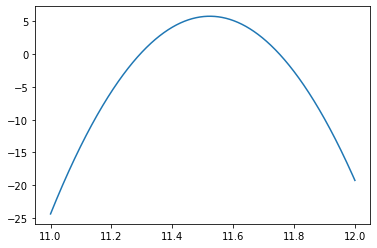

In [105]:
plt.plot(x, parabola(x1, -22.773, 530.660, -3085.583))

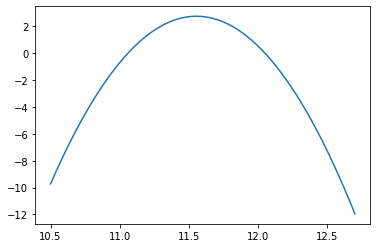

In [183]:
plt.plot(x1, parabola(x1,-11.211, 259.081, -1494.066))

# Catalina data

Using the numerical derivatives computed my Mario, with a R package using a smoothed spline.

## LASSO optimizer:

(notes from [Steve Brunton explain LASSO](https://www.youtube.com/watch?v=GaXfqoLR_yI&ab_channel=SteveBrunton))

LASSO (Least Absolute Shrinkage and Selection Operator) optimizer is used for interpretable selection model that not overfit the data. Introduced by Tibshirani in 1996 in paper Regression Shrinkage and Selection via the Lasso. How does it work?
The key idea is that we want interpretable model.
Like every computational problem a lot problems is reduced to a matrix multiplication:
$$b = Ax$$
where $b$ is the data vector, A the "feature" matrix for the data.
For example if we want the probability of lung cancer for m patients and data for age, battito cardiaco, weight, political preference and so on. 
In general A is not a square matrix or otherwise b has a different lenght than x.

Overdetermined case len(b)=A.shape[0]>A.shape[1]

Undetermined case len(b)=A.shape[0]<A.shape[1]

How we choose $x$?
In the least squares we want to find the x that minimize:
$$\underset{x}{\operatorname{argmin}} L(x),$$
where $L = || Ax - b||_2$
The problem is that with the least squares method is that x is dense and not sparse. But, a priori, we know that a lot of the factor does not matter. Moreover, it starts to become difficult to interprete.

Here, Lasso arrives:

$$L = ||Ax-b||_2 + \lambda||x||_1$$ 
This creates a very sparse $x$.
This highlight only some column in the A matrix. This help the interpretation. 

In [198]:
glob_DeltaScuti9 = glob.glob('./DeltaScuti9/*')

x' = 1.000 xdot
xdot' = -55.630 x + 0.248 xdot + 1.475 xdot^2 + -1.671


/Users/vecchia/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


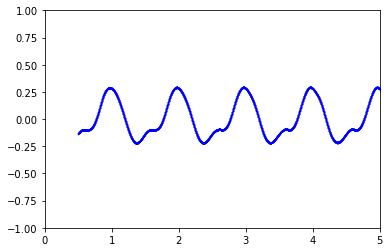

In [230]:
polynomial2 = ps.PolynomialLibrary(include_interaction=True, degree=2)
fourier2 = ps.FourierLibrary(n_frequencies=3)

from sklearn.linear_model import Lasso
lasso_optimizer = Lasso(alpha=0.1, max_iter=2000, fit_intercept=True)
rrderiv = pd.read_csv(glob_DeltaScuti9[0]) #I calculated the derivative with a spline here
Xt = rrderiv[['t', 'x', 'xdot']]
Xt = Xt.sort_values(by='t')
t = np.array(Xt[['t']])
X = np.array(Xt[['x', 'xdot']])
t = t.reshape((t.shape[0],))
model = ps.SINDy(feature_names=["x", "xdot"], feature_library=polynomial2, optimizer=lasso_optimizer)
model.fit(X, t=t)
model.print()
plt.xlim(0, 5)
plt.ylim(-1,1)
plt.scatter(t, X[:,0], s=0.2, c='b')
newt = np.linspace(t[0], t[-1], 1000)
s = model.simulate(X[0,:], newt)
#plt.scatter(newt, s[:,0], s=0.2, c='g')

In [225]:
import glob
import pandas as pd
import plotly.express as px

In [249]:
class Light_Curve2:
    def __init__(self, name):
        self.name = name
        self.phase = []
        self.df = pd.read_csv(self.name)
        
    def check_class(self):
        print('The name of the star is ' + self.name)
    
    
    def find_phase(self):
        with open(self.name) as f:
            self.first_line = f.readline()
            self.phase = float(self.first_line[18:-18])
            return self.phase
    
    def find_df(self):
        self.df = pd.read_csv(self.name)
        #return self.df        
    
    def add_name(self):
        self.find_df()
        self.df['star'] = '{0}'.format(self.name)
    
    def plot_lcv(self):
        if self.df == []:
            self.find_df()
            fig = px.scatter(self.df, x='phase', y='mag')
            fig.show()
        else:
            fig = px.scatter(self.df, x='phase', y='mag')
            fig.show()
            
    def sort_values(self, column):
        self.find_df()
        self.df = self.df.sort_values(by=column)
        
    def drop_duplicates(self, column):
        self.df = pd.DataFrame.drop_duplicates(self.df, subset=column)

        ### Sorto e droppo i duplicati per evitare problemi con sindy
        
    def sort_and_drop(self, column):
        self.find_df()
        self.sort_values(column)
        self.drop_duplicates(column)
    
    def repeat_phase(self, iteration):
        self.sort_and_drop('Phase')
        df1, df2 = self.df, pd.DataFrame.copy(self.df)
        for i in range(1, iteration):
            #print('phase :', i)
            df2['Phase'] += i
            df1, df2 = pd.concat([df1, df2]), pd.concat([df1, df2])
        self.df = df2
        return df2
    
    def sindy_time(self, iteration, feature_names, differentiation_method=FiniteDifference(order=2), 
                   optimizer=STLSQ(alpha=0.05), 
                   feature_library=PolynomialLibrary(degree=2)):
        
        model = ps.SINDy(feature_names=feature_names, differentiation_method=differentiation_method, 
                         optimizer=optimizer, 
                         feature_library=feature_library)
    
        
        model.fit(np.array(self.repeat_phase(iteration).Mag), np.array(self.repeat_phase(iteration).Phase))
#        model.print()
        return model
        

    

In [337]:
files_RRab = glob.glob("Send/RRab1_Mario/*")
prova = Light_Curve2(files_RRab[25])
prova.sindy_time(3, 'Mag')

array([[3077.34446514, -331.67164395,    8.91952164]])

## The new derivative journey

In [276]:
%matplotlib inline  
def showTheoreticalError(n):
    with plt.xkcd():
        fig = plt.figure(figsize=(9,4.5))
        ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        title = 'Schematic error of the FDM for $\mathcal{O}$';
        plt.title('{:s}$(h^{:d})$'.format(title, n) )
        plt.xlabel('spaceing $h$')
        plt.ylabel("error $\Delta$")
        plt.xticks([])
        plt.yticks([])
        h = np.linspace(0.0001,5, 200)
        plt.ylim(0,5)
        plt.xlim(0,5)
        plt.plot(h, h**n, dashes=[4,2])
        plt.plot(h, 1/h, dashes=[2,2])
        plt.plot(h, 1/h+h**n)
        plt.legend('best')
        
        plt.legend(['method error $\Delta_m(h)$', 'machine error $\Delta_r$', 'total error $\Delta_m+\Delta_r$'])
        plt.show()


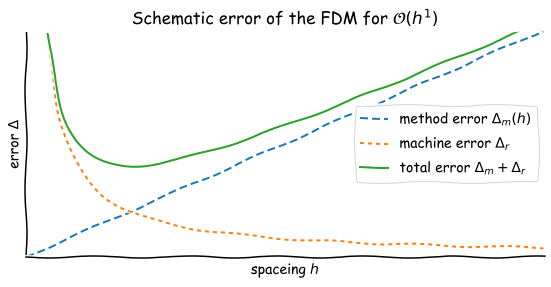

In [277]:
showTheoreticalError(n=1)

In [231]:
import jovian

In [232]:
jovian.commit('sindy-rrl-hires-asas')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "pierotrevisan-pt/sindy-rrl-hires-asas" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/pierotrevisan-pt/sindy-rrl-hires-asas


'https://jovian.ai/pierotrevisan-pt/sindy-rrl-hires-asas'